In [2]:
!pip install seaborn matplotlib pandas numpy tqdm rapidjson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 7.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 60.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.2 MB/s eta 0:00:00


In [3]:
from __future__ import annotations

import matplotlib
import rapidjson as json
import os
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from pandas import DataFrame as DF
from matplotlib import pyplot as plt
import seaborn as sns

In [14]:
fm = matplotlib.font_manager
fm._get_fontconfig_fonts.cache_clear()
sns.set(context='notebook', style='ticks', font='Source Han Sans CN', rc={'axes.unicode_minus': False})
plt.rcParams["font.sans-serif"] = ["Source Han Sans CN"] #设置字体
plt.rcParams["axes.unicode_minus"] = False #该语句解决图像中的“-”负号的乱码问题

In [5]:
from hypy_utils.tqdm_utils import tq, pmap, smap


def _helper(p: Path):
    return json.loads(p.read_text())

def load_data():
    dir = Path('index-data')
    files = [(dir / f) for f in tq(os.listdir(dir), 'Loading data') if f.endswith('.json')]
    return pmap(_helper, files, desc='Loading json')


data = load_data()
print(f'一共有 {len(data)} 個訂單')

Loading json: 100%|██████████| 135205/135205 [00:49<00:00, 2705.04it/s]

一共有 135205 個訂單


In [6]:
delivery = json.loads(Path('data/delivery.json').read_text())
delivery: dict[int, dict] = {d['id']: d for d in delivery}

for d in data:
    d['route'] = d['delivery_name'] + ' to ' + d['area_name']
    d['duration'] = ((d['receive_time'] - d['pay_time']) / 60 / 60 / 24) if d['receive_time'] != 0 else None
    d['real_package_price'] = float(d['real_package_price'])
    d['package_price'] = float(d['package_price'])
    d['price_diff'] = d['package_price'] - d['real_package_price']

    # d['delivery'] = delivery.get(d['delivery_id']) or {'id': d['delivery_id'], 'name': 'Unknown'}

所有運輸：
> 總訂單量： 135205
> 時間中數： 20.51 天
> 平均時間： 39.59 天
> 時間分佈：


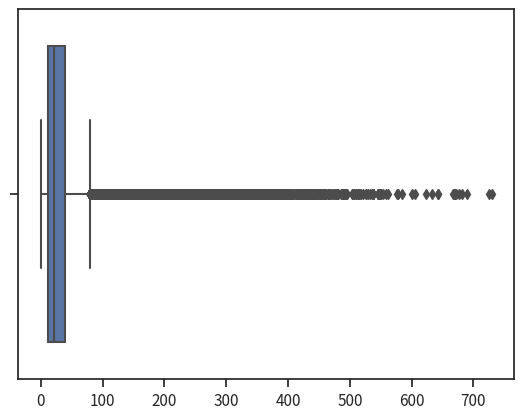

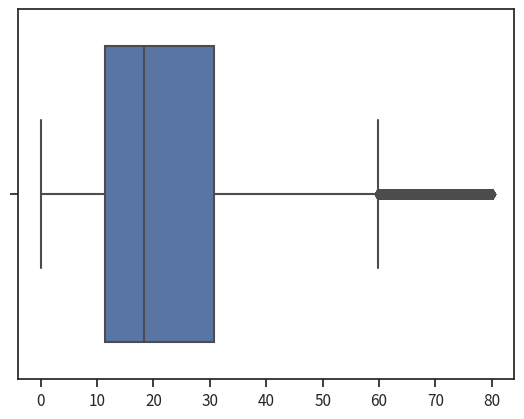

In [7]:
def overall_stats():
    durations = [d["duration"] for d in data if d["duration"]]

    print('所有運輸：')
    print(f'> 總訂單量： {len(data)}')
    print(f'> 時間中數： {np.median(durations):.2f} 天')
    print(f'> 平均時間： {np.mean(durations):.2f} 天')
    print(f'> 時間分佈：')

    sns.boxplot(x=durations)
    plt.show()
    sns.boxplot(x=[d for d in durations if d < 80])
    plt.show()

overall_stats()

總共有送往 99 個國家的訂單
集運目的國家統計： 前 30 國家的訂單數


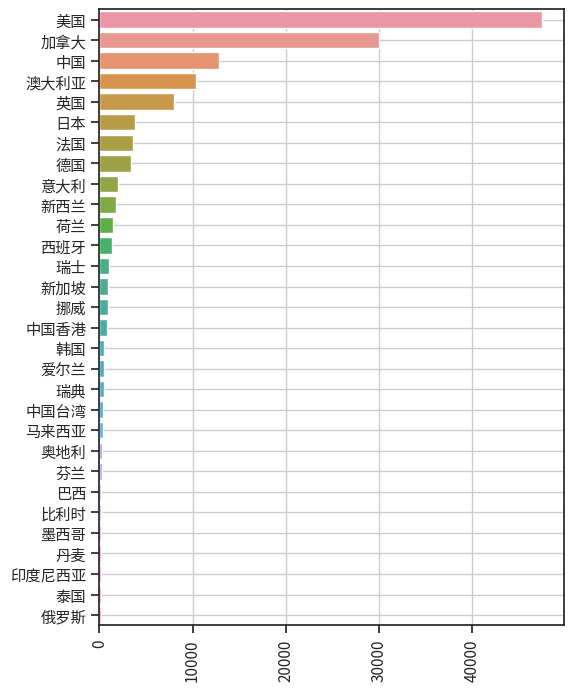

In [8]:
def bars(lst: list[tuple[str, int]]):
    plt.figure(figsize=(6, 8))
    sns.barplot(x=[v for k, v in lst], y=[k for k, v in lst], orient='h')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()


def country_stats():
    countries = sorted(Counter([d['area_name'] for d in data]).items(), key=lambda x: -x[1])
    print(f'總共有送往 {len(countries)} 個國家的訂單')
    countries = countries[:30]
    print('集運目的國家統計： 前 30 國家的訂單數')
    bars(countries)


country_stats()

正在分析送往全球的訂單數據...
總共有 155 個快遞公司
前 50 快遞公司的訂單數（圖1）和運輸時間天數（圖2,3）


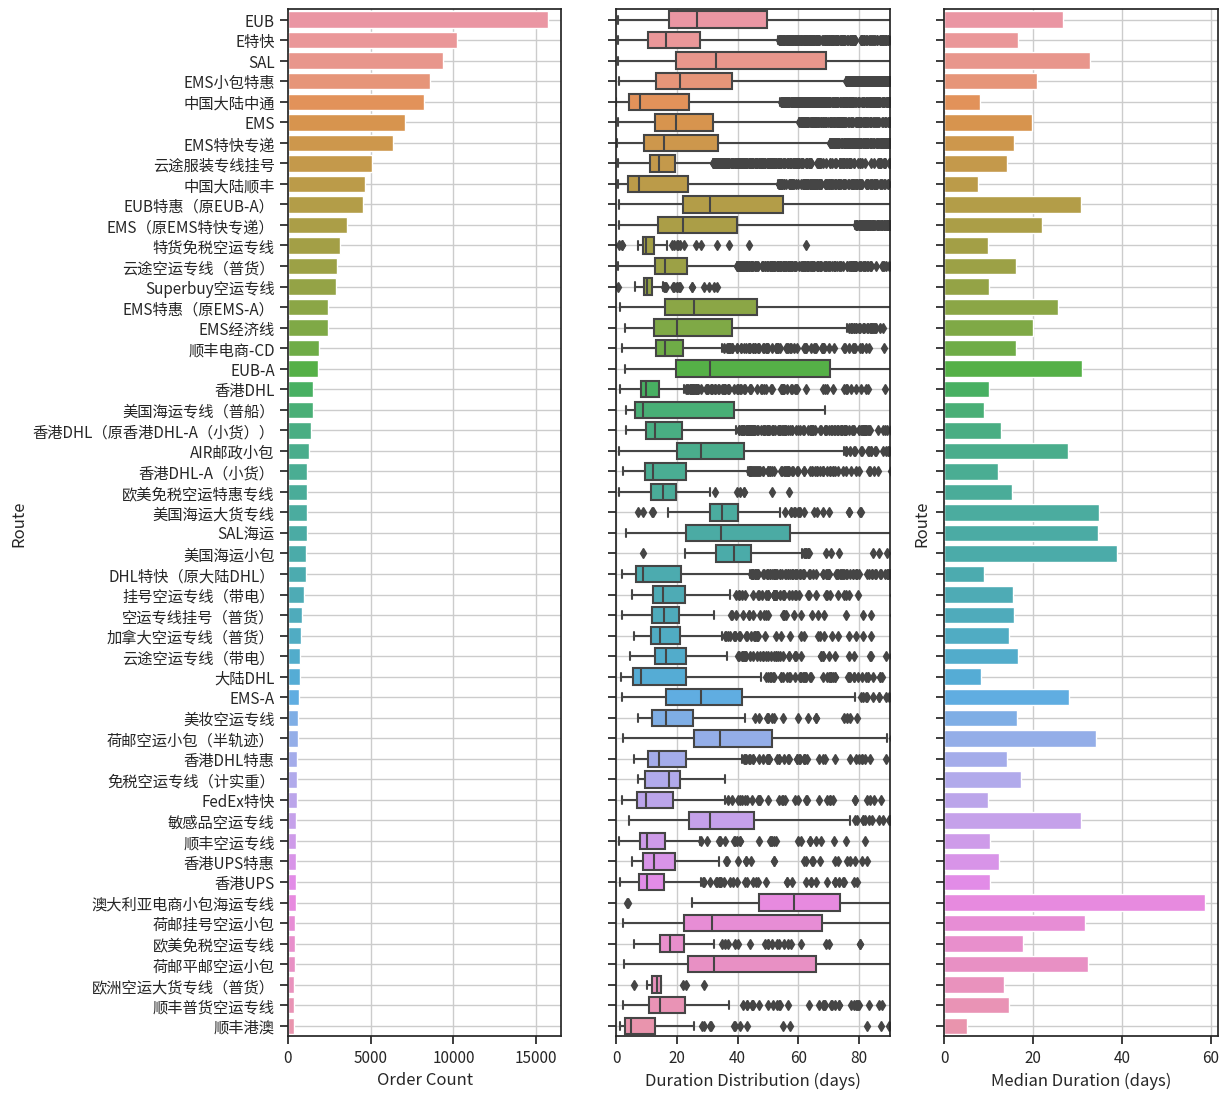

In [18]:
from matplotlib.figure import Figure

from matplotlib.axes import Axes


def route_stats(country: str | None = None, count: int = 30, sort_by: str | None = None, sort_asc: bool = True):
    cdata = data
    if country is not None:
        cdata = [d for d in data if d['area_name'] == country]
        print(f'正在分析送往 {country} 的訂單數據...')
    else:
        print('正在分析送往全球的訂單數據...')

    routes = sorted(Counter([d['delivery_name'].strip() for d in cdata]).items(), key=lambda x: -x[1])
    print(f'總共有 {len(routes)} 個快遞公司')
    routes = routes[:count]
    print(f'前 {count} 快遞公司的訂單數（圖1）和運輸時間天數（圖2,3）')
    # bars(names)

    df = []
    for route, cnt in routes:
        orders = [d for d in data if d['delivery_name'] == route]
        durations = [d['duration'] for d in orders if d['duration']]
        df.append({
            'Route': route,
            'Order Count': cnt,
            'Median Duration (days)': np.median(durations) if durations else 0,
            'Durations': durations,
            # 'Avg Price (USD/kg)': np.mean([d['real_package_price'] / d['final_weight'] for d in orders])
        })
    df = DF(df)

    if sort_by is not None:
        df = df.sort_values(sort_by, ascending=sort_asc)

    fig, ax = plt.subplots(ncols=3, figsize=(12, 8 / 30 * count), sharey='all')
    fig: Figure
    ax: list[Axes]

    sns.barplot(x='Order Count', y='Route', data=df, ax=ax[0], orient='h')
    sns.boxplot(data=df.Durations, ax=ax[1], orient='h')
    sns.barplot(x='Median Duration (days)', y='Route', data=df, ax=ax[2], orient='h')
    ax[1].set_xlabel('Duration Distribution (days)')
    ax[1].set_xlim(0, 90)
    for a in ax:
        a.grid()
    # ax[0].yaxis.set_ticks(list(df.Route))
    plt.show()


route_stats(count=50)

正在分析送往 加拿大 的訂單數據...
總共有 66 個快遞公司
前 50 快遞公司的訂單數（圖1）和運輸時間天數（圖2,3）


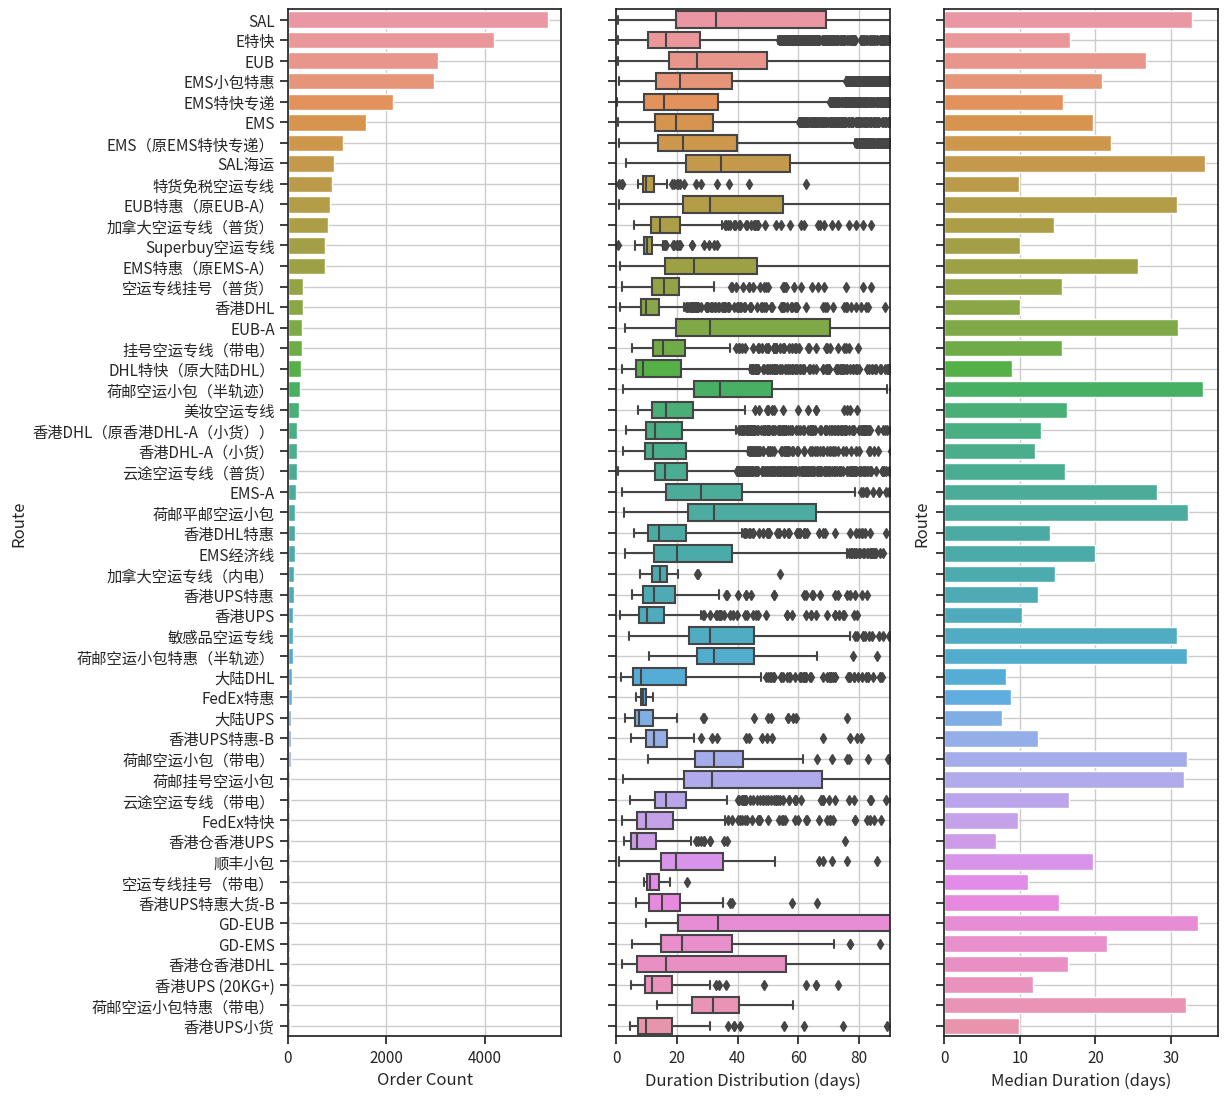

In [13]:
route_stats('加拿大', count=50)


正在分析送往 加拿大 的訂單數據...
總共有 66 個快遞公司
前 50 快遞公司的訂單數（圖1）和運輸時間天數（圖2,3）


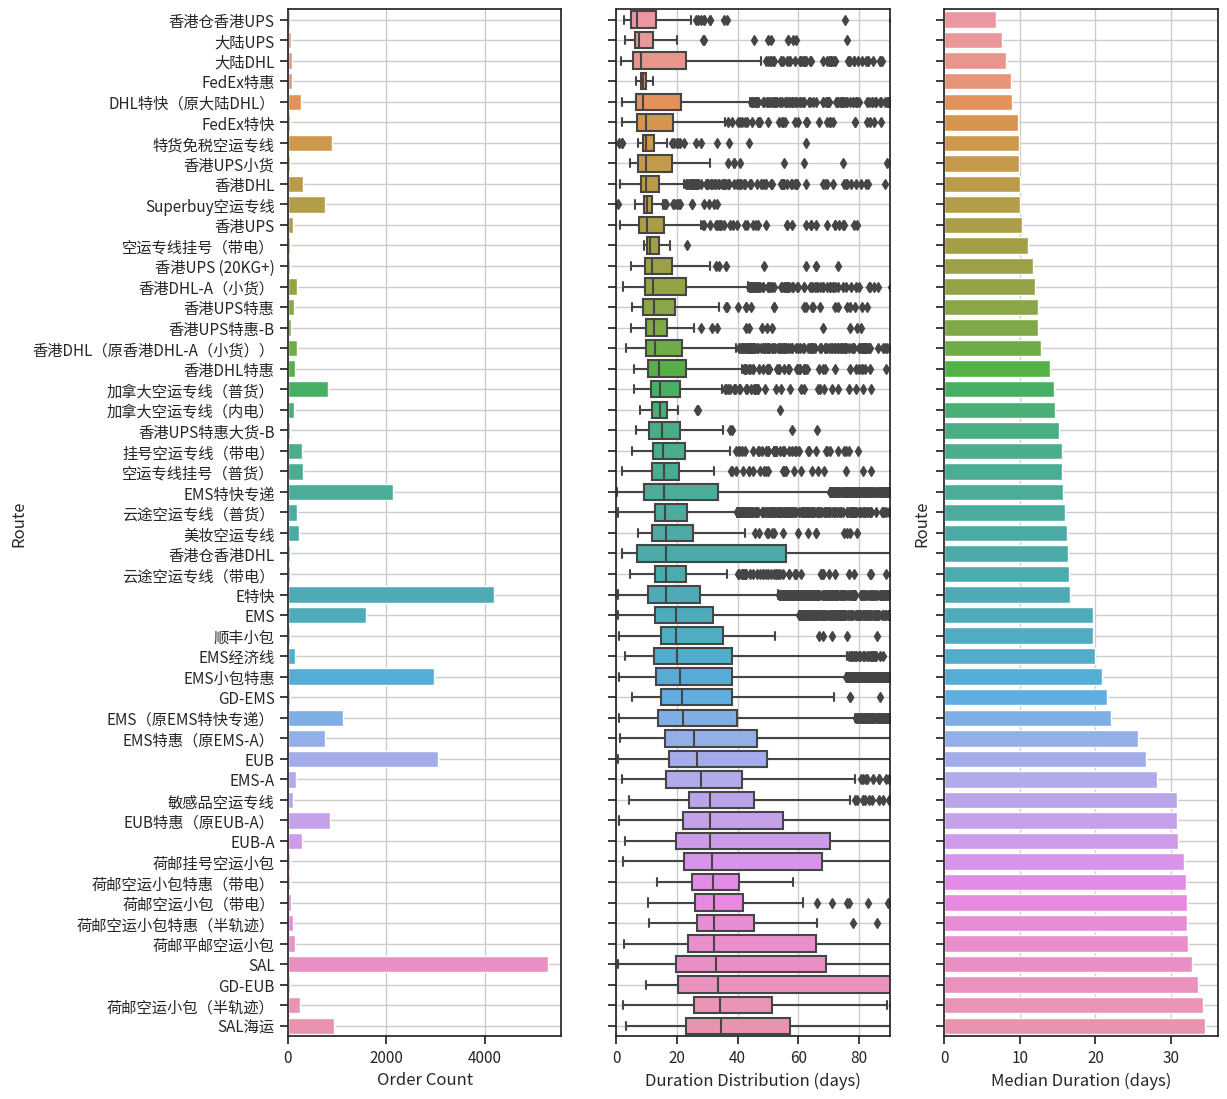

In [19]:
route_stats('加拿大', count=50, sort_by='Median Duration (days)')
